# Convolutional Neural Networks (CNNs)

### HW2 @ DL Course, Dr. Soleymani

*Full Name:* Ali Alvandi

*SID:* 400104748

In this homework, you will work with [Google colab](https://colab.research.google.com/). Google colab allows you to run a jupyter notebook on Google servers using a GPU/TPU. To enable GPU support, make sure to press `Runtime -> Change Runtime Type -> GPU`. 

## Task: Cats vs Dogs

To learn about CNNs we will be working on a problem of great importance in computer vision, **classifying images of cats and dogs** :)

The problem is so important that there's even an easter egg in colab: go to `Tools -> Settings -> Miscellaneous and enable 'Kitty mode' and 'Corgi mode'` to get more cats and dogs to classify when you're tired of coding :)

### Getting the data

To get started with the classification, we first need to download and unpack the dataset (note that in jupyter notebooks commands starting with `!` are executed in bash, not in python):

In [87]:
! wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2024-04-09 23:04:50--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.207, 209.85.200.207, 209.85.234.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: './cats_and_dogs_filtered.zip'

./cats_and_dogs_fil 100%[===================>]  65.43M   199MB/s    in 0.3s    

2024-04-09 23:04:50 (199 MB/s) - './cats_and_dogs_filtered.zip' saved [68606236/68606236]



In [88]:
! unzip -q cats_and_dogs_filtered.zip 

replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### Dataset Organization
Our dataset contains two directories, `train` and `validation`, both containing two directories with images: `cats` and `dogs`. In `train` we have 1000 images of cats and 1000 images of dogs. For `validation`, we have 500 images of each class. Our goal is to implement and train a CNN to classify these images, i.e. given an image from this dataset, tell if it contains a *cat* or a *dog*.

```bash
├── dir.txt
├── train
│   ├── cats
│   │   ├── cat.0.jpg
│   │   ├── cat....jpg
│   │   ├── cat.999.jpg
│   └── dogs
│       ├── dog.0.jpg
│       ├── dog....jpg
│       ├── dog.999.jpg
├── validation
│   ├── cats
│   │   ├── cat.2000.jpg
│   │   ├── cat....jpg
│   │   └── cat.2499.jpg
│   └── dogs
│       ├── dog.2000.jpg
│       ├── dog....jpg
│       └── dog.2499.jpg
└── vectorize.py

6 directories, 3002 files
```

### Loading the data
 Now that we have the data on our disk, we need to load it so that we can use it to train our model. In Pytorch, we use `Dataset` class, documentation for which can be found [here](https://pytorch.org/docs/stable/data.html). 

 Torchvision is a Pytorch library with many commonly used tools in computer vision. In the case of computer vision, the datasets with the folder structure `label_name/image_file` are very common, and to process those there's already an implemented class `torchvision.datasets.ImageFolder` (documented [here](https://pytorch.org/vision/0.8/datasets.html)). 

 Another thing we need from Torchvision library is [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html). In computer vision, we very often want to transform the images in certain ways. The most common is **normalization**. Others include *flipping*, changing *saturation*, *hue*, *contrast*, *rotation*, and *blurring*. 

 Below, we create training, validation and test sets. We use a few transforms for **augmentation** on the training set, but we don't use anything but **resize** and **normalization** for validation and test. 

In [90]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image

# These numbers are mean and std values for channels of natural images. 
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# Inverse transformation which is needed for plotting.
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

train_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(hue=.1, saturation=.1, contrast=.1),
                                    transforms.RandomRotation(20, interpolation=Image.Resampling.BILINEAR),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    transforms.ToTensor(), # This is necessary to convert PIL to torch Tensor
                                    normalize,
                                ])

validation_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(), 
                                    normalize,
                                ])

train_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/train', transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/validation', transform=validation_transforms)

validation_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [500, 500], generator=torch.Generator().manual_seed(42))

### Dataset Inspection
Let's see what one of the images in the dataset looks like (you can run this cell multiple times to see the effects of different augmentations):

torch.Size([3, 256, 256])


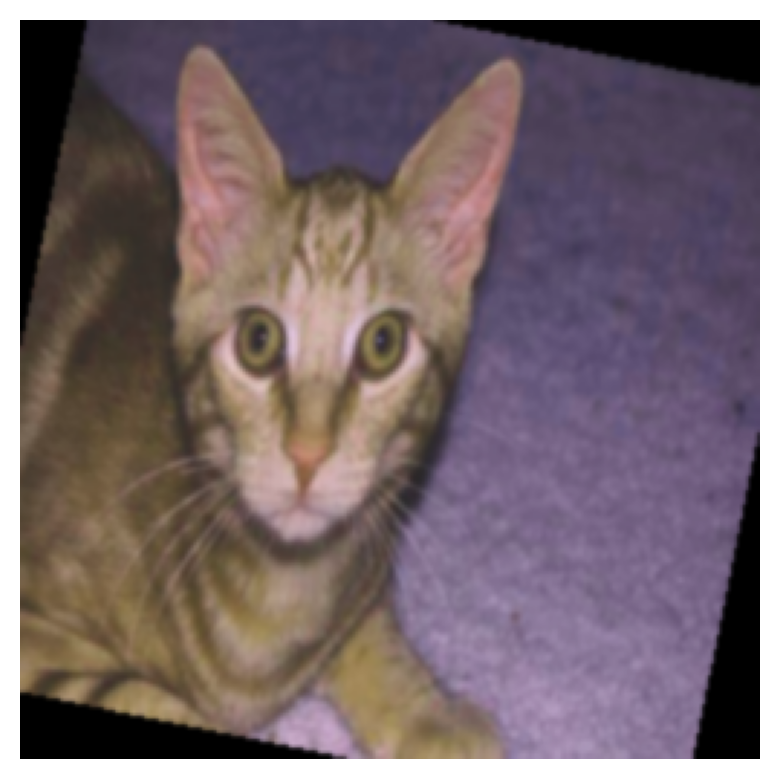

In [91]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 200 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
    plt.imshow(inv_normalize(img).detach().cpu().permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

print(train_dataset[10][0].shape)
show_normalized_image(train_dataset[10][0])

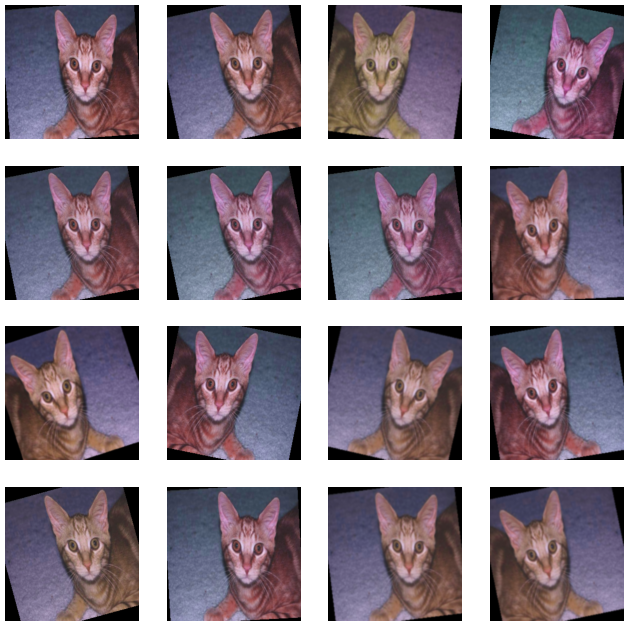

In [92]:
# checking the augmentation
plt.rcParams['figure.dpi'] = 50
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    show_normalized_image(train_dataset[10][0])
plt.show()

In [93]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Creating the model

Now is the time to create a model. 

All models in Pytorch are subclassing `torch.nn.Module`. We have to implement `__init__` and `forward` methods. 

Below we provide a simple model skeleton, which you need to expand. The places to put your code are marked with `TODO`. Here, we ask you to implement a CNN containing the following elements:

* Convolutional layers (at least two)
* Pooling layers
* Non-linearity
* Residual connections similar to that of **ResNet**
* fully connected layer(s)

Note that you cannot use Batch Normalization layers in this step.

In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_cat_dog(torch.nn.Module):

    def __init__(self, num_classes=2):
        super(CNN_cat_dog, self).__init__()
        # TODO
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        
        
        self.fc1 = nn.Linear(61 * 61 * 64, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # TODO
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
                
#         out = out.reshape(out.size(0), -1)
        out= out.view(-1,61 * 61 * 64)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [95]:
model = CNN_cat_dog()
model.to(device)

CNN_cat_dog(
  (conv_layer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=238144, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

### Training the model

Now we train the model on the dataset. Again, we're providing you with the skeleton with some parts marked as `TODO` to be filled by you.

In [96]:
from tqdm.notebook import tqdm
import torch.optim as optim

def get_loss_and_correct(model, batch, criterion, device):
    # Implement forward pass and loss calculation for one batch.
    # Remember to move the batch to device.
    # 
    # Return a tuple:
    # - loss for the batch (Tensor)
    # - number of correctly classified examples in the batch (Tensor)
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    
    loss = criterion(outputs, labels)

    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()

    return loss, correct



def step(loss, optimizer):
    # Implement backward pass and update.
    # TODO
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [97]:
N_EPOCHS = 10 # TODO
BATCH_SIZE = 32 # TODO
def training(model, criterion, optimizer, num_epochs, batch_size = 32 ,num_worker =4):
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=4)
    model = CNN_cat_dog()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss() # TODO
    optimizer = optim.Adam(model.parameters(), lr=0.001) # TODO


    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []

    pbar = tqdm(range(num_epochs))

    for i in pbar:
        total_train_loss = 0.0
        total_train_correct = 0.0
        total_validation_loss = 0.0
        total_validation_correct = 0.0

        model.train()

        for batch in tqdm(train_dataloader, leave=False):
            # use `get_loss_and_correct` to perform a step and save train loss and corrects
            # TODO
            loss, correct = get_loss_and_correct(model, batch, criterion, device)
            total_train_loss += loss.item()
            total_train_correct += correct
            step(loss, optimizer)
        
        mean_train_loss = total_train_loss / len(train_dataloader.dataset)
        train_accuracy = total_train_correct / len(train_dataloader.dataset)

        with torch.no_grad():
            for batch in validation_dataloader:
                # use `get_loss_and_correct` to perform a step and save validation loss and corrects
                # TODO 
                loss, correct = get_loss_and_correct(model, batch, criterion, device)
                total_validation_loss += loss.item()
                total_validation_correct += correct

        mean_validation_loss = total_validation_loss / len(validation_dataloader.dataset)
        validation_accuracy = total_validation_correct / len(validation_dataloader.dataset)


        train_losses.append(mean_train_loss)
        validation_losses.append(mean_validation_loss)

        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)

        pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})
    return train_losses, validation_losses, train_accuracies, validation_accuracies

In [99]:
model = CNN_cat_dog()
model.to(device)
train_losses, validation_losses, train_accuracies, validation_accuracies = training(model, None, None, 20, 32, 4)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Now that the model is trained, we want to visualize the training and validation losses and accuracies:

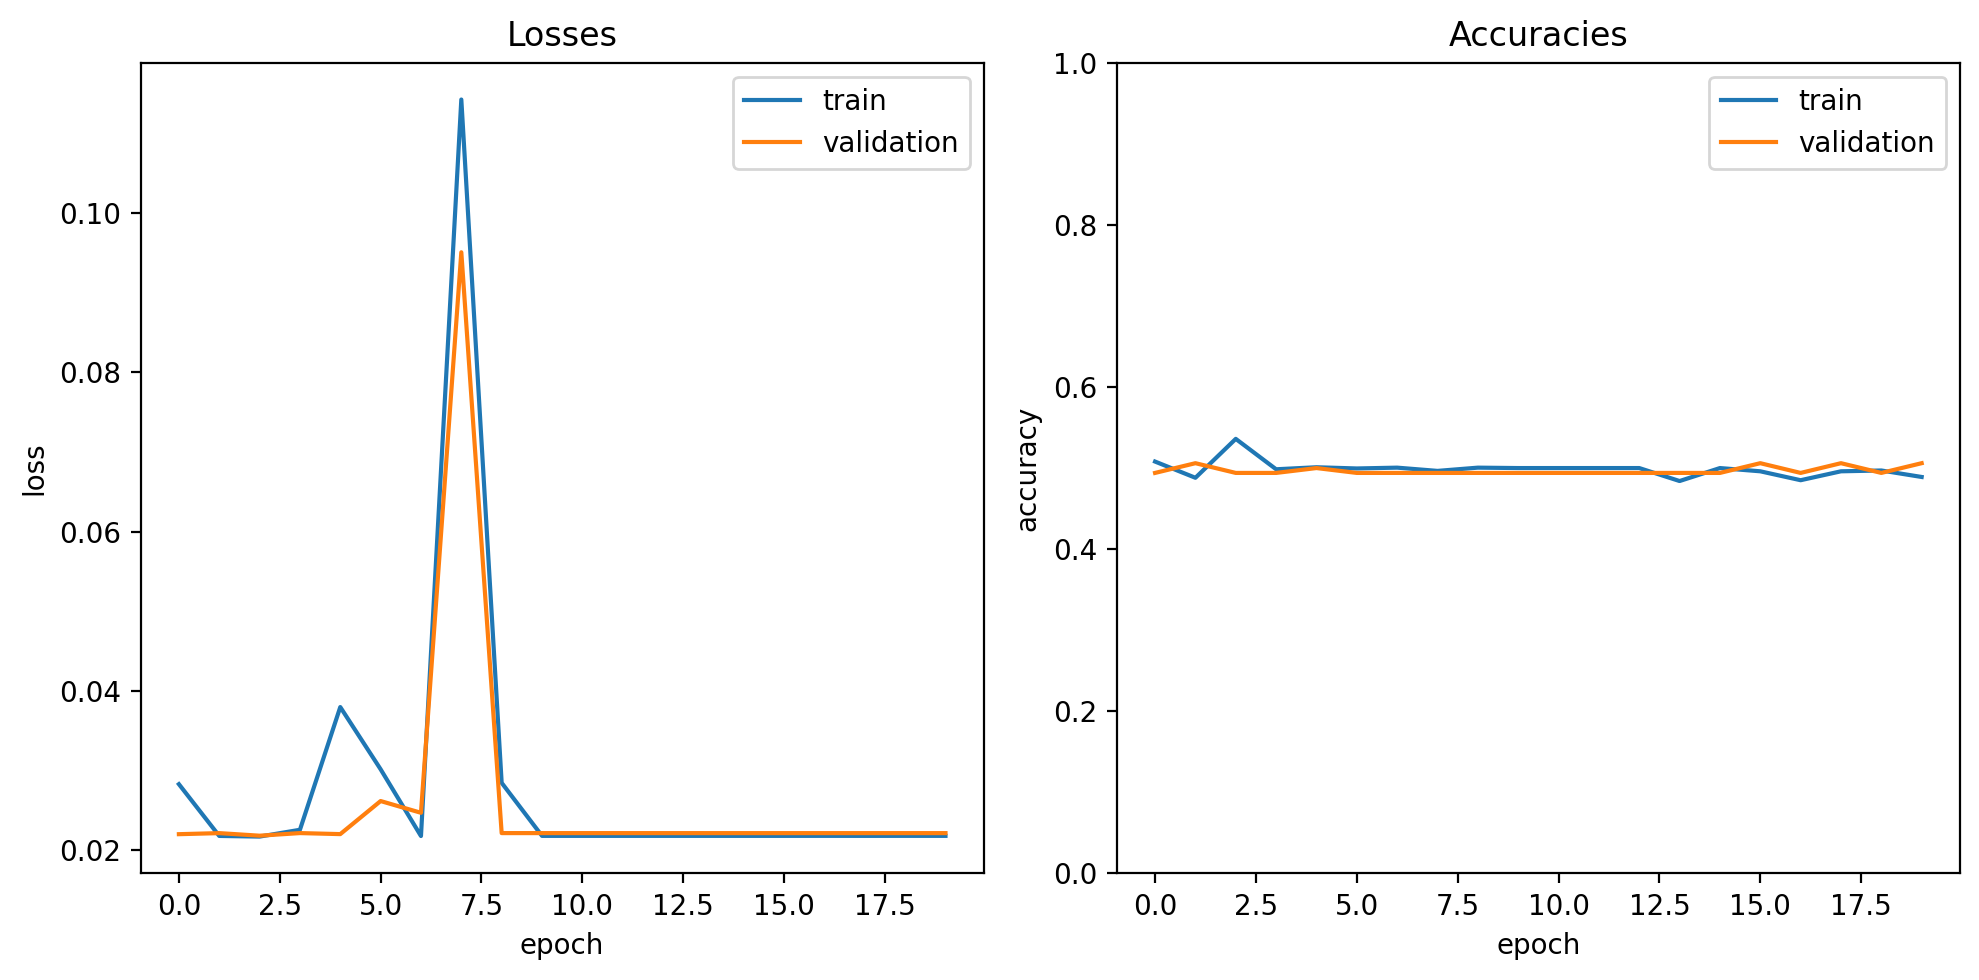

In [100]:
plt.figure(dpi=200, figsize=(10, 5))

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()
plt.show()

Now, change your model to achieve at least 75% accuracy on validation set. Add Dropout and Batch Norm layers where needed. You can change the model you've implemented (including the model depth, activation functions, etc.), the optimizer (including the regularizer terms), and the augmentations. 

#### Question
Looking at the loss and accuracy plots, can you see if your model overfits the trainig set? Why?


Training Loss vs. Validation Loss:

If the training loss decreases continuously while the validation loss starts to increase after some point, it indicates that the model is likely overfitting. This happens because the model is memorizing the training data too well and fails to generalize to unseen data, leading to a higher validation loss.
Training Accuracy vs. Validation Accuracy:

Similar to the loss plots, if the training accuracy continues to increase while the validation accuracy stagnates or starts to decrease, it suggests overfitting. The model is becoming too specialized in the training data and is unable to generalize well to new data.

In [27]:
# Change your model to achieve better accuracies
# TODO
class CNN_cat_dog(torch.nn.Module):

    def __init__(self, num_classes=2):
        super(CNN_cat_dog, self).__init__()
        # TODO
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.max_pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.dropout3 = nn.Dropout(0.25)
        
        self.conv_layer4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.max_pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.dropout4 = nn.Dropout(0.25)
        
        
        self.fc1 = nn.Linear(14 * 14 * 128, 512)
        self.relu1 = nn.ReLU()
        self.batch_norm5 = nn.BatchNorm1d(512)
        self.dropout5 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # TODO
        out = self.conv_layer1(x)
        out = F.relu(out)
        out = self.batch_norm1(out)
        out = self.max_pool1(out)
        out = self.dropout1(out)
        
        out = self.conv_layer2(out)
        out = F.relu(out)
        out = self.batch_norm2(out)
        out = self.max_pool2(out)
        out = self.dropout2(out)
        
        out = self.conv_layer3(out)
        out = F.relu(out)
        out = self.batch_norm3(out)
        out = self.max_pool3(out)
        out = self.dropout3(out)
        
        out = self.conv_layer4(out)
        out = F.relu(out)
        out = self.batch_norm4(out)
        out = self.max_pool4(out)
        out = self.dropout4(out)
                
#         out = out.reshape(out.size(0), -1)
        out= out.view(-1,14 * 14 * 128)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.batch_norm5(out)
        out = self.dropout5(out)
        out = self.fc2(out)
        return out

In [30]:
model = CNN_cat_dog()
model.to(device)
train_losses, validation_losses, train_accuracies, validation_accuracies = training(model, None, None, 50, 32, 4)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

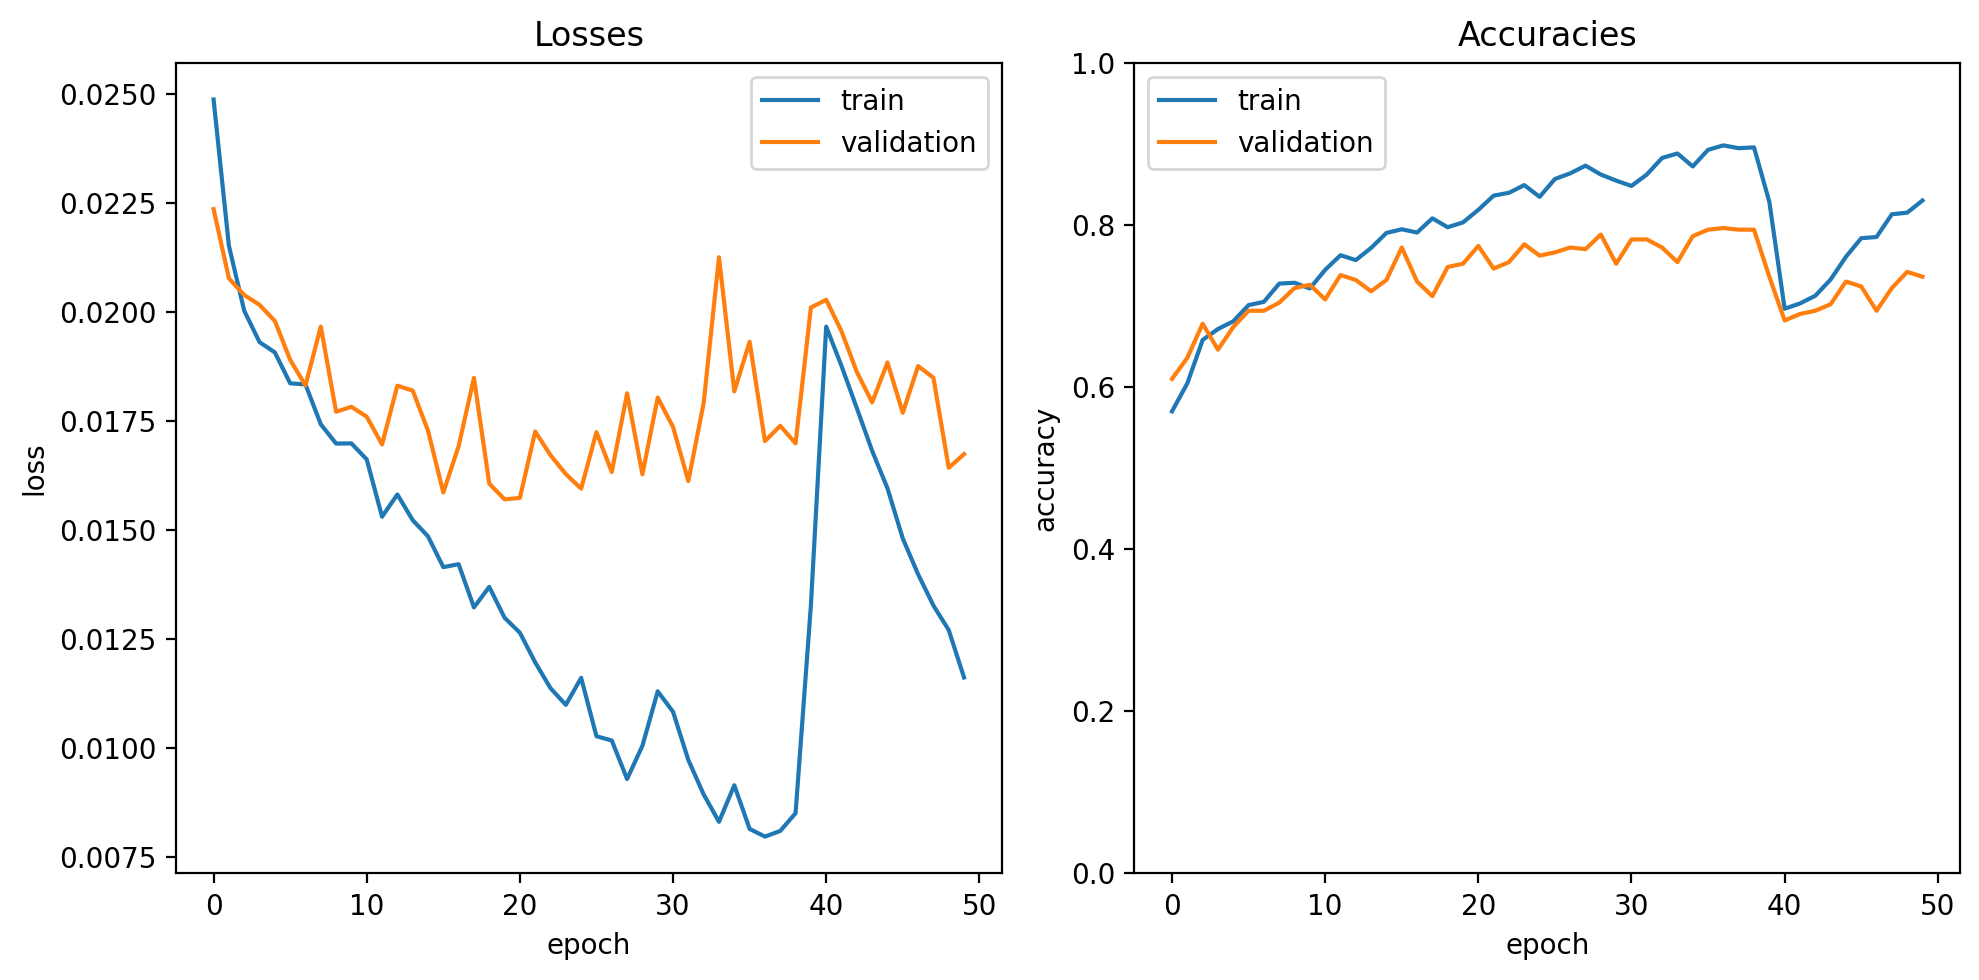

In [31]:
plt.figure(dpi=200, figsize=(10, 5))

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()
plt.show()

### Testing the model

Now, use the `test_dataset` to get the final accuracy of your model. Visualize some correctly and incorrectly classified examples.

Test Accuracy: 77.64%

Correctly Classified Images:


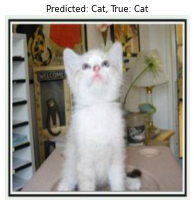

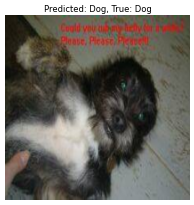

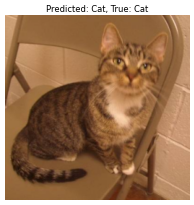

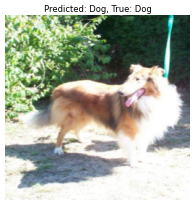

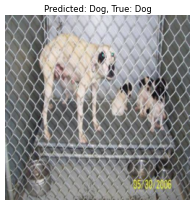


Incorrectly Classified Images:


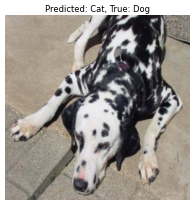

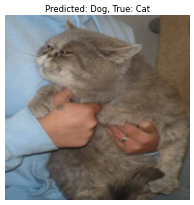

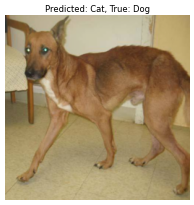

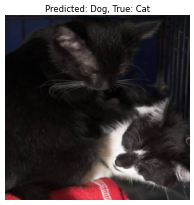

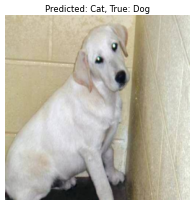

In [102]:
# TODO
# 1. Calculate and show the test_dataset accuracy of your model.
# 2. Visualize some correctly and incorrectly classified examples.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


def imshow(img, title):
    img = inv_normalize(img)
    img = torch.Tensor.cpu(img).numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

model.eval()
correct = 0
total = 0
classes = ['Cat', 'Dog']
correct_images = []
incorrect_images = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if predicted == labels:
            correct_images.append((images.squeeze(), classes[predicted.item()], classes[labels.item()]))
        else:
            incorrect_images.append((images.squeeze(), classes[predicted.item()], classes[labels.item()]))

accuracy = 100 * correct / total
print('Test Accuracy: {:.2f}%'.format(accuracy))

print("\nCorrectly Classified Images:")
for i in range(min(5, len(correct_images))):
    img, pred, true_label = correct_images[i]
    imshow(img, f'Predicted: {pred}, True: {true_label}')

print("\nIncorrectly Classified Images:")
for i in range(min(5, len(incorrect_images))):
    img, pred, true_label = incorrect_images[i]
    imshow(img, f'Predicted: {pred}, True: {true_label}')

### Visualizing filters

In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's get some image.

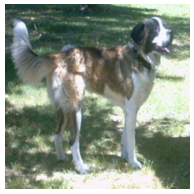

In [57]:
image = validation_dataset[10][0]
show_normalized_image(image)

Now, we are going to *clip* our model at different points to get different intermediate representation. 
* Clip your model at two or three different points and plot the filters output.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 4 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



Intermediate Output Shape for Layer 1: torch.Size([1, 6, 254, 254])


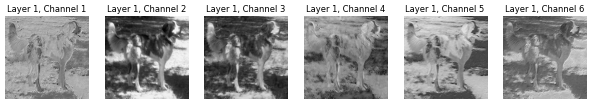

Intermediate Output Shape for Layer 2: torch.Size([1, 6, 127, 127])


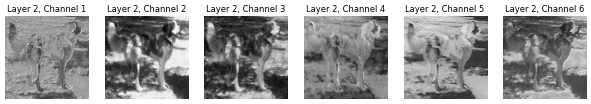

Intermediate Output Shape for Layer 3: torch.Size([1, 6, 125, 125])


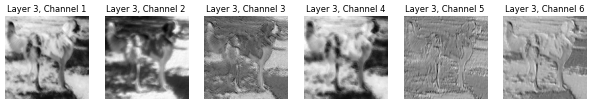

In [63]:
clipped_models = [nn.Sequential(*list(model.children())[:2]), nn.Sequential(*list(model.children())[:4]), nn.Sequential(*list(model.children())[:6])]



for i, clipped_model in enumerate(clipped_models):
    with torch.no_grad():
        intermediate_output = clipped_model(torch.Tensor.cuda(image).unsqueeze(0))
        intermediate_output = intermediate_output[:, :6]
        print(f"Intermediate Output Shape for Layer {i+1}: {intermediate_output.shape}")
        # Visualize
        fig, axes = plt.subplots(1, 6, figsize=(15, 5))
        for j in range(6):
            axes[j].imshow(intermediate_output[0, j].cpu().numpy(), cmap='gray')
            axes[j].axis('off')
            axes[j].set_title(f'Layer {i+1}, Channel {j+1}')
        plt.show()


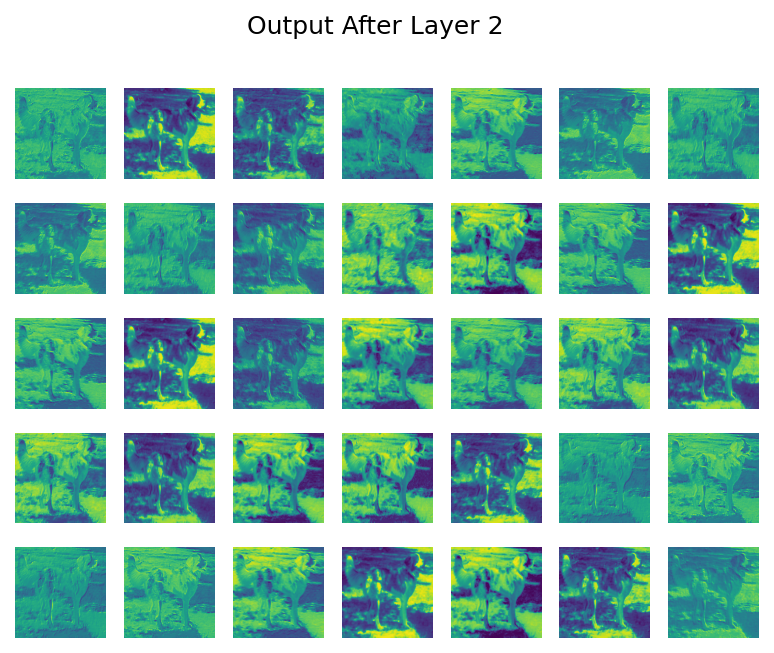

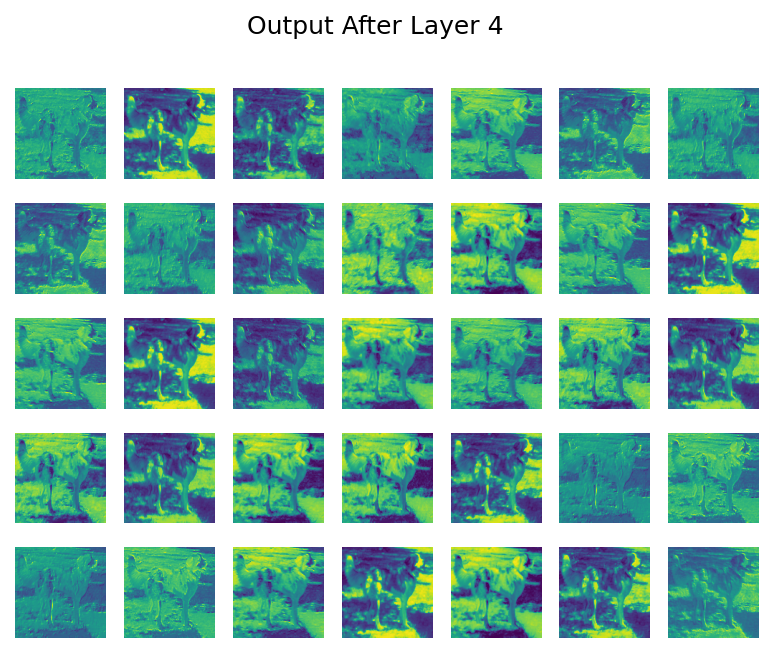

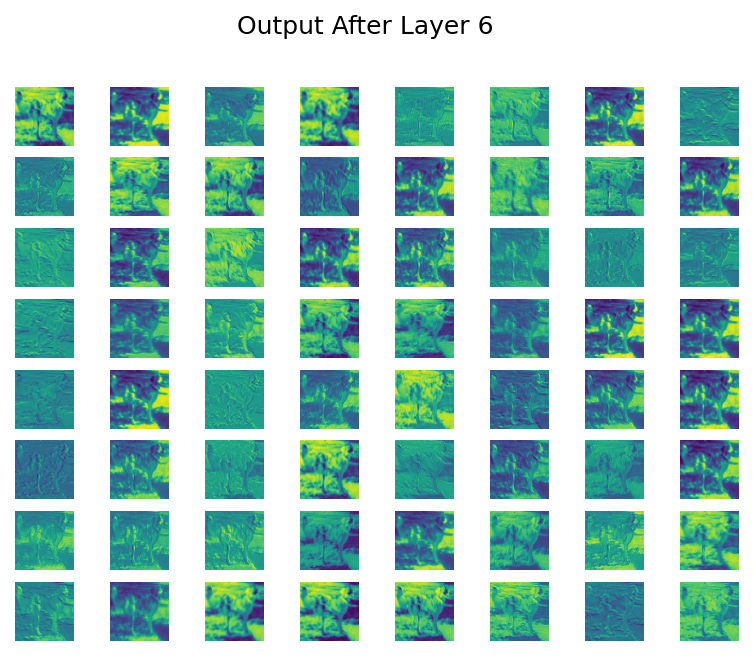

In [67]:
import math

def plot_intermediate_output(result, title=None):
    """ Plots the intermediate output of shape
      N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')

# TODO: 
# pick a few intermediate representations from your 
# network and plot them using the provided function.
clipped_models = [nn.Sequential(*list(model.children())[:2]), nn.Sequential(*list(model.children())[:4]), nn.Sequential(*list(model.children())[:6])]
for clipped_model in clipped_models:
    with torch.no_grad():
        intermediate_output = clipped_model(torch.Tensor.cuda(image).unsqueeze(0))
    plot_intermediate_output(intermediate_output, title=f'Output After Layer {len(clipped_model)}')



### Question
What can you say about those filters? What features are they focusing on?

Early Convolutional Layers (First and Second Clipping Points):

Filters in early layers tend to capture low-level features such as edges, corners, and textures.
These filters are typically sensitive to basic patterns and shapes present in the input images.
Features like gradients, color variations, and simple textures are emphasized.

Intermediate Convolutional Layers (Third Clipping Point):

Filters in intermediate layers start to capture more complex and abstract features.
They may focus on detecting patterns that are combinations of low-level features captured in earlier layers.
These filters might be sensitive to parts of objects, specific textures, or other mid-level features that are relevant for classification tasks.
Features like textures, object parts (e.g., ears, eyes), or patterns become more prominent.

Later Convolutional Layers (Deeper Clipping Points):

Filters in deeper layers tend to capture high-level features that are more specific to the target classes.
They may represent more abstract concepts such as object categories or semantic features.
These filters are specialized in detecting complex patterns and configurations of features across the input space.
Features like object shapes, object configurations, or object-specific textures dominate.

Overall, as we move deeper into the network, the filters become more specialized and selective, focusing on increasingly abstract and class-specific features. These features are crucial for the network to effectively discriminate between different classes in the classification task.